In [23]:
import psycopg2

In [24]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [25]:
try:
    cursor.execute("SELECT * FROM all_pairs_counts")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [26]:
print("Number of pairs:", len(pairs), "\nFirst pair and count:", pairs[0])

Number of pairs: 3070458 
First pair and count: ('eelmine', 'aasta', 53250)


### Number of pairs per threshold

Choosing thresholds and counting how many pairs are left if that threshold is applied. So for example if threshold is 10, then all pairs that occurred 10 times or less in the used texts are dropped and the number of pairs remaining is counted.

In [27]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

#### Threshold from 0 to 100

In [6]:
number_of_pairs = defaultdict(int)

for i in range(100):
    new_pairs = [pair for pair in pairs if pair[2] > i]
    number_of_pairs[i] = len(new_pairs)

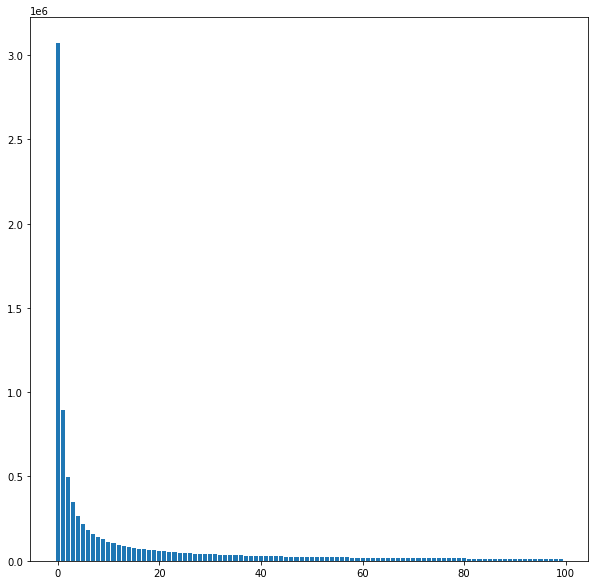

In [7]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*number_of_pairs.items()))
plt.show()

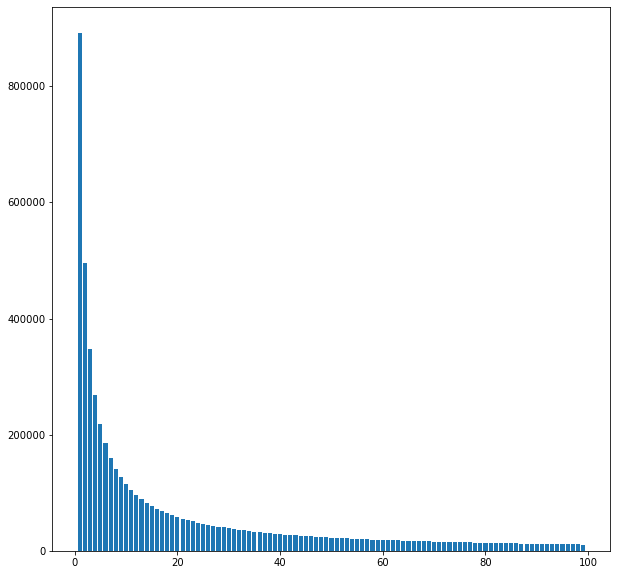

In [8]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*list(number_of_pairs.items())[1:]))
plt.show()

#### Threshold from 0 to 1000 with a step of 10

In [9]:
number_of_pairs_10 = defaultdict(int)

for i in range(0, 1000, 10):
    new_pairs = [pair for pair in pairs if pair[2] > i]
    number_of_pairs_10[i] = len(new_pairs)

In [10]:
number_of_pairs_10[990]

490

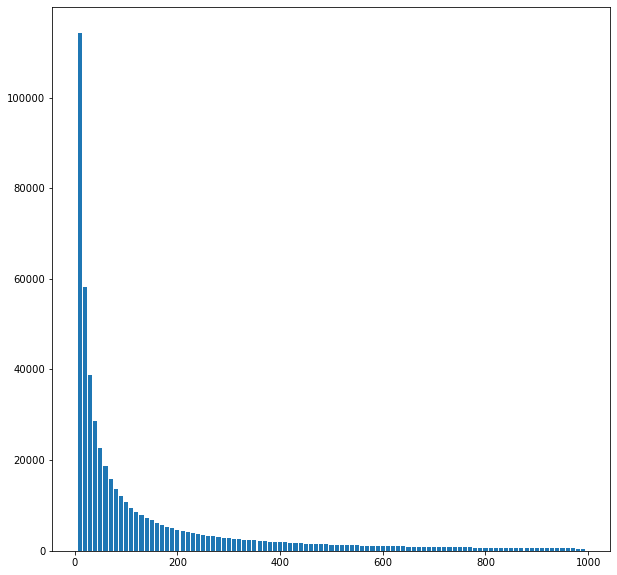

In [11]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*list(number_of_pairs_10.items())[1:]), width=8)
#plt.xticks(rotation=45)
#plt.setp(cbar.ax.get_xticklabels()[::2], visible=False)
#[label.set_visible(False) for i, label in enumerate(ax.xaxis.get_ticklabels()) if i % 10 != 0]
plt.show()

#### How many times the 100 most popular pairs appeared in the texts

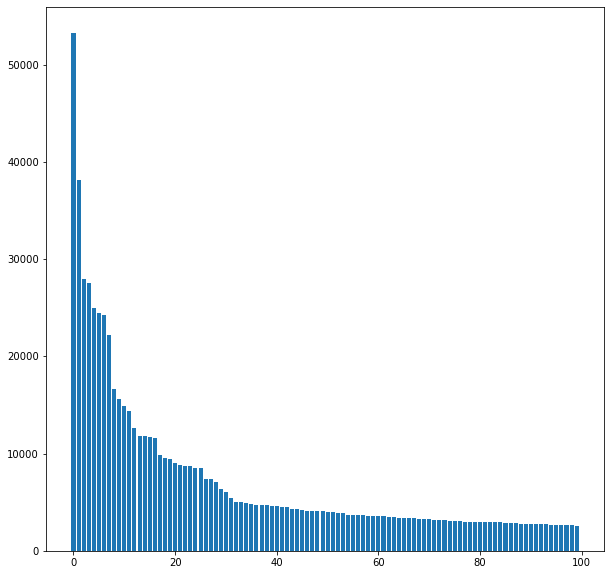

In [12]:
plt.figure(figsize=(10, 10))
plt.bar(range(100), [pair[2] for pair in pairs[:100]])
plt.show()

In [13]:
pairs[99]

('avalik', 'kord', 2599)

In [14]:
pairs[:10]

[('eelmine', 'aasta', 53250),
 ('järgmine', 'aasta', 38107),
 ('viimane', 'aeg', 27915),
 ('käesolev', 'määrus', 27514),
 ('kogu', 'aeg', 24997),
 ('viimane', 'aasta', 24410),
 ('kohalik', 'omavalitsus', 24261),
 ('suur', 'osa', 22165),
 ('suur', 'tänu', 16634),
 ('eelmine', 'nädal', 15648)]

#### Percentage of pairs over threshold

In [15]:
from copy import deepcopy

In [16]:
stat_per_threshold = {}

new_pairs = deepcopy(pairs)

for i in range(pairs[0][2] + 1):
    new_pairs = [pair for pair in new_pairs if pair[2] > i]
    stat_per_threshold[i] = (len(new_pairs), len(new_pairs) / len(pairs) * 100) # saving as number of pairs and percentage of pairs left per threshold, as I'm iterating until all pairs are dropped and may want to use all stats later

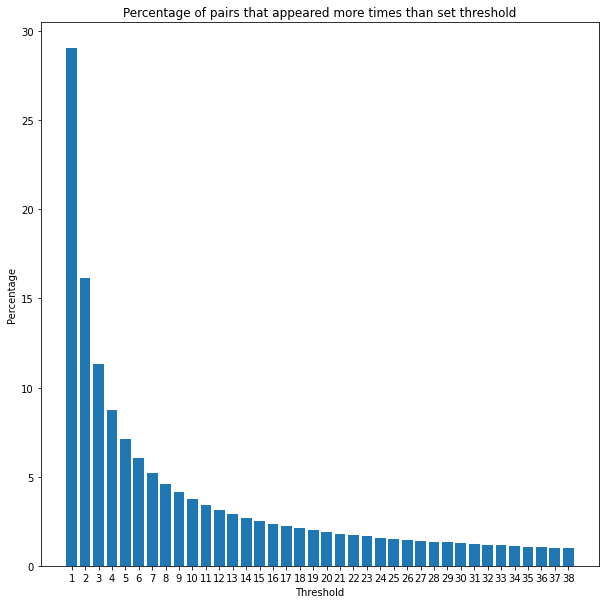

In [19]:
plt.figure(figsize=(10, 10))
plt.bar(list(range(1, 39)), [stat_per_threshold[i][1] for i in range(1, 39)])
plt.title("Percentage of pairs that appeared more times than set threshold")
plt.xlabel("Threshold")
plt.ylabel("Percentage")
plt.xticks(list(range(1, 39)))
plt.show()

### Power law

In [20]:
from plotnine import *
import pandas as pd

In [21]:
stats = [(key, value[0], value[1]) for key, value in stat_per_threshold.items()]

In [22]:
df = pd.DataFrame(stats, columns=['threshold','count' , 'percentage'])
df

,threshold,count,percentage
0,0,3070458,100.000000
1,1,891727,29.042149
2,2,496057,16.155798
3,3,347644,11.322220
4,4,268116,8.732117
...,...,...,...
53246,53246,1,0.000033
53247,53247,1,0.000033
53248,53248,1,0.000033
53249,53249,1,0.000033


In [23]:
df2 = df.drop_duplicates('count')

In [24]:
df2

,threshold,count,percentage
0,0,3070458,100.000000
1,1,891727,29.042149
2,2,496057,16.155798
3,3,347644,11.322220
4,4,268116,8.732117
...,...,...,...
24997,24997,4,0.000130
27514,27514,3,0.000098
27915,27915,2,0.000065
38107,38107,1,0.000033


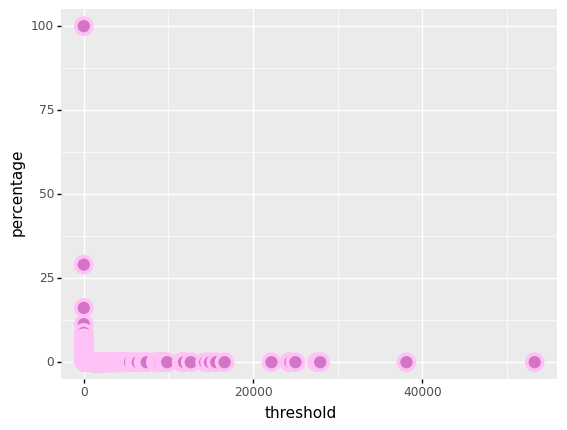

<ggplot: (-9223371870588730620)>

In [25]:
fig_og = (
    ggplot(data=df2) +
    aes(x = 'threshold', y = 'percentage') + 
    geom_point(fill = '#d175c4', 
               size = 5,
               stroke = 1.5,
               colour = '#ffc2f6',
               shape = 'o')
)
fig_og

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


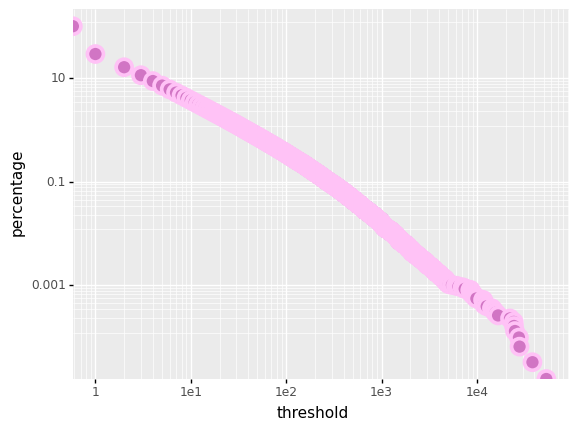

<ggplot: (166266050203)>

In [26]:
fig = (
    ggplot(data=df2) +
    aes(x = 'threshold', y = 'percentage') + 
    geom_point(fill = '#d175c4', 
               size = 5,
               stroke = 1.5,
               colour = '#ffc2f6',
               shape = 'o') +
    scale_x_log10() +
    scale_y_log10()
)
fig

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
lr = LinearRegression()
lr.fit(np.log10(df2[['threshold']]).drop(df2.tail(1).index).drop(df2.head(1).index), np.log10(df2[['percentage']].drop(df2.tail(1).index).drop(df2.head(1).index)))

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10


LinearRegression()

In [29]:
print(lr.coef_, lr.intercept_)

[[-1.3648971]] [2.27536039]


C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


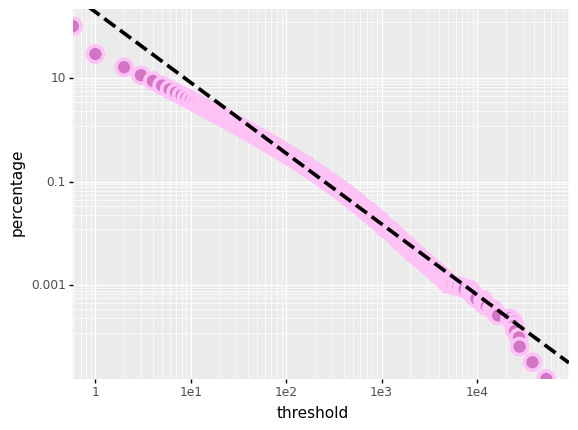

<ggplot: (166266039037)>

In [30]:
fig = fig + geom_abline(intercept = lr.intercept_, slope = lr.coef_[0], color="black", linetype="dashed", size=1.5)
fig

#### Finding differences in predictions

In [32]:
predictions = lr.predict(np.log10(df2[['threshold']]).drop(df2.tail(1).index).drop(df2.head(1).index))

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10


In [33]:
predicted_percentages = [10**pred for pred in predictions]

In [34]:
indexes = []
idx = 0

for i, row in df2.drop(df2.tail(1).index).drop(df2.head(1).index).iterrows():
    if abs((row['percentage'] - predicted_percentages[idx])[0]) <= 5:
        indexes.append(i)
    idx += 1

In [35]:
new_df = df2.loc[indexes]

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


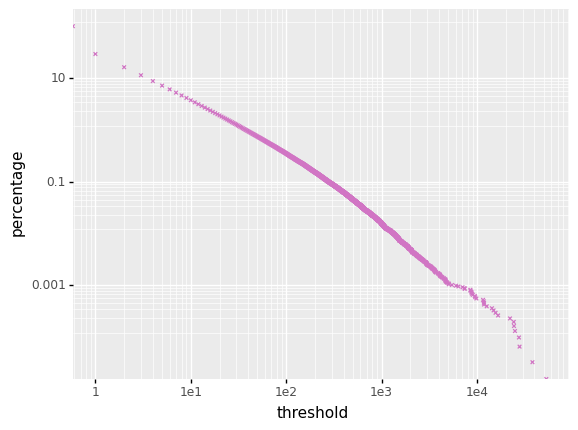

<ggplot: (-9223371870588569319)>

In [49]:
fig2 = (
    ggplot(data=df2) +
    aes(x = 'threshold', y = 'percentage') + 
    geom_point(fill = '#d175c4', 
               size = 1,
               stroke = 0.5,
               colour = '#ffc2f6',
               shape = 'x') +
    scale_x_log10() +
    scale_y_log10()
)
fig2

In [37]:
lr2 = LinearRegression()
lr2.fit(np.log10(new_df[['threshold']]), np.log10(new_df[['percentage']]))

LinearRegression()

In [38]:
print(lr2.coef_, lr2.intercept_)

[[-1.39651069]] [2.36687784]


C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


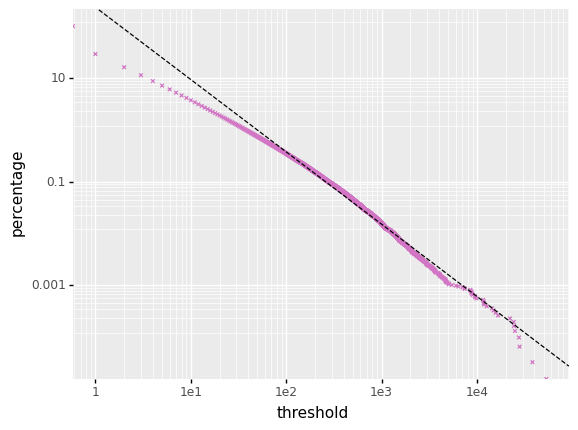

<ggplot: (166266200626)>

In [50]:
fig2 = fig2 + geom_abline(intercept = lr2.intercept_, slope = lr2.coef_[0], color="black", linetype="dashed", size=0.5)
fig2

### Exploring examples of different thresholds

In this section I will look at examples that occurred very few times (ie once, twice etc) and check the texts corresponding to them to see if the pairs are true or false positive. This will help set the final threshold that determines what pairs are used for dividing words into clusters.

In [55]:
import random
import estnltk
from estnltk.storage.postgres import PostgresStorage

In [56]:
storage = PostgresStorage(host="postgres.keeleressursid.ee",
                          dbname="estonian-text-corpora",
                          user="sormusbi",
                          password="", #enter password
                         port=5432,
                         schema="estonian_text_corpora")

INFO:storage.py:42: connecting to host: 'postgres.keeleressursid.ee', port: 5432, dbname: 'estonian-text-corpora', user: 'sormusbi'
INFO:storage.py:58: schema: 'estonian_text_corpora', temporary: False, role: 'sormusbi'


In [57]:
collection = storage['koondkorpus_base_v2']
collection.selected_layers = ['v166_morph_analysis', 'v166_sentences']

DEBUG:pg_operations.py:75: SELECT table_name, pg_size_pretty(pg_total_relation_size('estonian_text_corpora'||'.'||table_name)), obj_description(('estonian_text_corpora'||'.'||table_name)::regclass), S.n_live_tup FROM information_schema.tables LEFT JOIN pg_stat_user_tables S ON S.relname = table_name AND S.schemaname = table_schema WHERE table_schema='estonian_text_corpora' AND table_type='BASE TABLE';
DEBUG:pg_operations.py:75: SELECT table_name, pg_size_pretty(pg_total_relation_size('estonian_text_corpora'||'.'||table_name)), obj_description(('estonian_text_corpora'||'.'||table_name)::regclass), S.n_live_tup FROM information_schema.tables LEFT JOIN pg_stat_user_tables S ON S.relname = table_name AND S.schemaname = table_schema WHERE table_schema='estonian_text_corpora' AND table_type='BASE TABLE';


#### Pairs that occurred only once 

In [6]:
once = [pair for pair in pairs if pair[2] == 1]

In [7]:
len(once)

2178731

In [9]:
once_samples = random.sample(once, 10)

Get ids of the texts these pairs were extracted from, so I could check whether the pair in the text made sense or if it was a false positive.

In [11]:
once_samples[0]

('kuiv', 'uksetihend', 1)

In [12]:
pairs_with_ids = []

for sample in once_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids.append(cursor.fetchone()) # fetchone is sufficient because all of these pairs appeared only once anyway and are thus present only once

In [13]:
pairs_with_ids

[('kuiv', 'uksetihend', 527340, 'artikkel'),
 ('läinud', 'meeleavaldus', 200070, 'artikkel'),
 ('oletatav', 'palgamäär', 288748, 'artikkel'),
 ('üldine', 'elumüra', 184648, 'artikkel'),
 ('tüüpiline', 'enamus', 429896, 'artikkel'),
 ('kunagine', 'kaubakompanii', 2692, 'artikkel'),
 ('ajalooline', 'alibi', 436824, 'artikkel'),
 ('tänane', 'ristiisa', 343723, 'artikkel'),
 ('vanune', 'inff', 678745, 'kommentaarid'),
 ('uus', 'lavakultuur', 4234, 'artikkel')]

In [20]:
sample_texts = []

for pair in pairs_with_ids:
    sample_texts.append(collection[pair[2]])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(527340)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(200070)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(288748)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(184648)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(429896)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(2692)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2

In [36]:
for idx, text in enumerate(sample_texts):
    pair = once_samples[idx]
    noun = pair[1]
    print(pair[0], pair[1])
    
    for sentence in text.v166_sentences:
        for morph in sentence.v166_morph_analysis:
            if morph.lemma[0] == noun:
                print(' '.join(sentence.text))
                break
    print("-"*50)

kuiv uksetihend
Üksiti puhutakse pesuveest kuivaks uksetihendid .
--------------------------------------------------
läinud meeleavaldus
Vene noorukite laamendamiseks üle läinud meeleavaldus USA saatkonna ees pärast Eesti ühinemist Iraagi-vastase koalitsiooniga .
--------------------------------------------------
oletatav palgamäär
" Siis oleks eelmisel koosseisul võimalus sätestada järgmise koosseisu liikmetele ühiskondlikult vastuvõetav palgamäär ja selle muutumise mehhanism , mis ei oleks otseselt sõltuv täitevvõimu otsustest , " tähendab rahandusminister Siim Kallas BNSile .
" Praegu ei oska ta igal juhul öelda , milline võiks oletatav kindel palgamäär olla , mis ehk kunagi tulevikus riigi majanduslikust edust sõltuda võiks .
Haugi sõnul on teoreetiliselt konkreetse palgamäära kinnitamine võimalik , aga sisuliselt vale otsus .
--------------------------------------------------
üldine elumüra
Tuleval nädalavahetusel Tartus peetaval Improvizzi festivalil hakkavad korraldajad Eesti ja

Järeldus: pooled on valepositiivsed (vanune inff, kunagine kaubakompanii, tüüpiline enamus, läinud meeleavaldus, kuiv uksetihend), mis on üsna suur osa, eriti kuna paare, mida leidus tekstides vaid üks kord, oli väga palju (üle 2 miljoni paari), siis kui nii suur osa nendest on valepositiivsed, mõjutab see tulemusi kindlasti kehvasti.

#### Pairs that occurred twice

In [44]:
twice = [pair for pair in pairs if pair[2] == 2]

In [45]:
len(twice)

395670

In [46]:
twice_samples = random.sample(twice, 10)

In [47]:
twice_samples[0]

('kuuluv', 'soojustrass', 2)

In [53]:
pairs_with_ids_2 = []

for sample in twice_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_2.append(cursor.fetchall())

In [54]:
pairs_with_ids_2

[[('kuuluv', 'soojustrass', 420668, 'artikkel'),
  ('kuuluv', 'soojustrass', 366222, 'artikkel')],
 [('plaanitav', 'sulgemine', 486742, 'artikkel'),
  ('plaanitav', 'sulgemine', 68738, 'artikkel')],
 [('ehitatav', 'mudel', 301786, 'artikkel'),
  ('ehitatav', 'mudel', 301887, 'artikkel')],
 [('kohalik', 'pall', 101082, 'artikkel'),
  ('kohalik', 'pall', 458907, 'artikkel')],
 [('individuaalne', 'juhtum', 3235, 'artikkel'),
  ('individuaalne', 'juhtum', 388015, 'tervikteos')],
 [('professionaalne', 'lõhkaja', 6234, 'artikkel'),
  ('professionaalne', 'lõhkaja', 6234, 'artikkel')],
 [('sealne', 'väiketootja', 298009, 'artikkel'),
  ('sealne', 'väiketootja', 365453, 'artikkel')],
 [('vabariiklik', 'tööinspektsioon', 445483, 'artikkel'),
  ('vabariiklik', 'tööinspektsioon', 704489, 'stenogramm')],
 [('pakkuv', 'alune', 287177, 'artikkel'),
  ('pakkuv', 'alune', 81289, 'artikkel')],
 [('ametlik', 'teovõime', 59179, 'artikkel'),
  ('ametlik', 'teovõime', 386318, 'artikkel')]]

In [55]:
sample_texts_2 = []

for pair in pairs_with_ids_2:
    sample_texts_2.append([collection[pair[0][2]], collection[pair[1][2]]])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(420668)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(366222)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(486742)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(68738)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301786)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301887)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [58]:
for idx, texts in enumerate(sample_texts_2):
    pair = twice_samples[idx]
    noun = pair[1]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            for morph in sentence.v166_morph_analysis:
                if morph.lemma[0] == noun:
                    print(' '.join(sentence.text))
                    break
    print("-"*50)

kuuluv soojustrass 

Text nr 1
Endise Tallinna-nimelise hotelli laiendamine ja renoveerimine on takerdunud soojustrassi ja segase seadusandluse taha .
Hotellitöödel on aga tekkinud segadused kinnistut läbiva Tallinna Soojusele kuuluva soojustrassiga , mistõttu linnaplaneerimisamet peatas osaliselt ehitustööd .
Tallinna hotelli renoveerimisel puhkes soojustrassi pärast tüli , kuna renoveerija OÜ Wicom ühendas lahti kinnistut läbiva soojustrassi .

Text nr 2
Tallinna linnavalitsus otsustas eilsel istungil võtta vastu tänavu juba teine lisaeelarve , millega suunatakse soojustrasside müügist saadav 26,4 miljonit krooni tänavate remondiks .
Valisime teise tee ning linnale kuuluvate soojustrasside näol me vajalikud lisavahendid ka leidsime .
Soojustrasside müümine Tallinna Soojusele ei muuda linlaste jaoks soojatarbimise osas mitte midagi , küll aga muutub linna liiklus selle tulemusena elanikele tunduvalt mugavamaks ja turvalisemaks .
--------------------------------------------------
plaan

Järeldus: valepositiivsed on kuuluv soojustrass, kohalik pall, pakkuv alune

ehitatav mudel - mitte otseselt valepositiivne, kuid leidus tegelikkuses vaid kord, sest kaks erinevat teksti langesid kokku (sama tekstiallikas, kuid erinev rubriik) <br>
ametlik teovõime - sama, mis eelmine (tundus olevat sama tekst, kuid erinevatest allikatest - üks Eesti Ekspressi, teine Eesti Päevalehe artikkel)

Samuti üsna väike hulk päriselt positiivseid

In [3]:
import estnltk
from estnltk import Text

In [4]:
naide = Text("Õhtul oli õnneks vaba aega , siis saime kohalikega palli mängida .")

In [11]:
naide.tag_layer()

Text(text='Õhtul oli õnneks vaba aega , siis saime kohalikega palli mängida .')

In [12]:
naide.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Õhtul', [{'normalized_text': 'Õhtul', 'lemma': 'õhtu', 'root': 'õhtu', 'root_tokens': ['õhtu'], 'ending': 'l', 'clitic': '', 'form': 'sg ad', 'partofspeech': 'S'}]),
Span('oli', [{'normalized_text': 'oli', 'lemma': 'olema', 'root': 'ole', 'root_tokens': ['ole'], 'ending': 'i', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('õnneks', [{'normalized_text': 'õnneks', 'lemma': 'õnn', 'root': 'õnn', 'root_tokens': ['õnn'], 'ending': 'ks', 'clitic': '', 'form': 'sg tr', 'partofspeech': 'S'}]),
Span('vaba', [{'normalized_text': 'vaba', 'lemma': 'vaba', 'root': 'vaba', 'root_tokens': ['vaba'], 'ending': '0', 'clitic': '', 'form': 'sg p', 'partofspeech': 'A'}]),
Span('aega', [{'normalized_text': 'aega', 'lemma': 'aeg', 'root': 'aeg', 'root_tokens': ['aeg'], 'ending': '0', 'clitic': '', 'form': 'sg p', 'partofspeech': 'S'}]),
Span(',', [{'normalized_text': ',', 'lemma': ',', 'root': ',', 'root_tokens': [','], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}]),
Span('siis', [{'normalized_text': 'siis', 'lemma': 'siis', 'root': 'siis', 'root_tokens': ['siis'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'J'}]),
Span('saime', [{'normalized_text': 'saime', 'lemma': 'saama', 'root': 'saa', 'root_tokens': ['saa'], 'ending': 'ime', 'clitic': '', 'form': 'sime', 'partofspeech': 'V'}]),
Span('kohalikega', [{'normalized_text': 'kohalikega', 'lemma': 'kohalik', 'root': 'kohalik', 'root_tokens': ['kohalik'], 'ending': 'ega', 'clitic': '', 'form': 'pl kom', 'partofspeech': 'A'}]),
Span('palli', [{'normalized_text': 'palli', 'lemma': 'pall', 'root': 'pall', 'root_tokens': ['pall'], 'ending': '0', 'clitic': '', 'form': 'sg p', 'partofspeech': 'S'}]),
Span('mängida', [{'normalized_text': 'mängida', 'lemma': 'mängima', 'root': 'mängi', 'root_tokens': ['mängi'], 'ending': 'da', 'clitic': '', 'form': 'da', 'partofspeech': 'V'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

##### Examples of two texts that were pretty much the same and caused a pair (ametlik teovõime) to appear twice because of it

In [128]:
collection[301786]

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301786)])])


Text(text='Antti Oolo\n\nPresidendi ametiauto riigihanke konkursil lubasid kindlasti osaleda Audide , Mercedeste , Volvode ja BMW-de maaletoojad ; autofirmade esindajad kinnitasid , et teevad presidendile hinnaalandust .\n\nReval Auto tegevjuhi Aivar Toompere sõnul pakub nende firma presidendile pikendatud kerega luksusautot Audi A8L .\n\nMercedeseid müüva firma Silberauto pressiesindaja Üllar Born ütles , et praegu pole firmas otsustatud , millist Mercedese mudelit nad presidendile pakuvad . Traditsioonide kohaselt on Eesti president seni sõitnud Mercedesega , lausus Born .\n\nBMW-d esindava firma United Motors müügidirektori Toomas Pärna sõnul pole nad täpselt otsustanud , millist autot presidendile pakkuda , kuid konkursil osaleb firma igal juhul .\n\nUnited Motors pakub presidendile vanemat 7-seeria BMW pikendatud kerega mudelit , kuna uusima mudeli pikendatud kerega variant valmib alles tuleva aasta märtsiks .\n\nVolvosid müüva Info-Auto turundusdirektori Tiit Lillipuu sõnul pakuvad nemad presidendile eritellimusel pikendatud kerega ehitatavat mudelit Volvo S80 .\n\nPresidendi ametiauto riigihanke konkursil osalemise tähtaeg on 7. jaanuaril kell 11.')

In [129]:
collection[301887]

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301887)])])


Text(text='Antti Oolo\n\nPresidendi ametiauto riigihanke konkursil lubasid kindlasti osaleda Audide , Mercedeste , Volvode ja BMW-de maaletoojad ; autofirmade esindajad kinnitasid , et teevad presidendile hinnaalandust .\n\nReval Auto tegevjuhi Aivar Toompere sõnul pakub nende firma presidendile pikendatud kerega luksusautot Audi A8L .\n\nMercedeseid müüva firma Silberauto pressiesindaja Üllar Born ütles , et praegu pole firmas otsustatud , millist Mercedese mudelit nad presidendile pakuvad . " Traditsioonide kohaselt on Eesti president seni sõitnud Mercedesega , " lausus Born .\n\nBMW-d esindava firma United Motors müügidirektori Toomas Pärna sõnul pole nad täpselt otsustanud , millist autot presidendile pakkuda , kuid konkursil osaleb firma igal juhul .\n\nUnited Motors pakub presidendile vanemat 7-seeria BMW pikendatud kerega mudelit , kuna uusima mudeli pikendatud kerega variant valmib alles tuleva aasta märtsiks .\n\nVolvosid müüva Info-Auto turundusdirektori Tiit Lillipuu sõnul pakuvad nemad presidendile eritellimusel pikendatud kerega ehitatavat mudelit Volvo S80 .\n\nPresidendi ametiauto riigihanke konkursil osalemise tähtaeg on 7. jaanuaril kell 11.')

#### Pairs that occurred three times

In [66]:
three = [pair for pair in pairs if pair[2] == 3]

In [67]:
len(three)

148413

In [68]:
three_samples = random.sample(three, 10)

In [69]:
three_samples[0]

('vapper', 'sõna', 3)

In [70]:
pairs_with_ids_3 = []

for sample in three_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_3.append(cursor.fetchall())

In [71]:
pairs_with_ids_3

[[('vapper', 'sõna', 11871, 'artikkel'),
  ('vapper', 'sõna', 406418, 'artikkel'),
  ('vapper', 'sõna', 667520, 'artikkel')],
 [('tähistav', 'monument', 84780, 'artikkel'),
  ('tähistav', 'monument', 483267, 'artikkel'),
  ('tähistav', 'monument', 228686, 'artikkel')],
 [('25aastane', 'õpetaja', 581898, 'artikkel'),
  ('25aastane', 'õpetaja', 569721, 'artikkel'),
  ('25aastane', 'õpetaja', 488547, 'artikkel')],
 [('edukas', 'äriühing', 698380, 'stenogramm'),
  ('edukas', 'äriühing', 251544, 'artikkel'),
  ('edukas', 'äriühing', 379451, 'dissertatsioon')],
 [('märkimisväärne', 'teade', 13168, 'artikkel'),
  ('märkimisväärne', 'teade', 411629, 'artikkel'),
  ('märkimisväärne', 'teade', 447554, 'artikkel')],
 [('juhtiv', 'maksukonsultant', 173684, 'artikkel'),
  ('juhtiv', 'maksukonsultant', 379379, 'dissertatsioon'),
  ('juhtiv', 'maksukonsultant', 333609, 'artikkel')],
 [('napp', 'sissekanne', 311972, 'artikkel'),
  ('napp', 'sissekanne', 383367, 'artikkel'),
  ('napp', 'sissekanne', 38

In [72]:
sample_texts_3 = []

for pair in pairs_with_ids_3:
    sample_texts_3.append([collection[pair[i][2]] for i in range(3)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(11871)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(406418)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(667520)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(84780)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(483267)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(228686)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2

In [98]:
for idx, texts in enumerate(sample_texts_3):
    pair = three_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
            #for morph in sentence.v166_morph_analysis:
                #if morph.lemma[0] == noun:
                #    print(' '.join(sentence.text))
                #    break
    print("-"*50)

vapper sõna 

Text nr 1
Kõigist neist vapratest sõ-nadest hoolimata on Clinto-ni mõjuvõim Washingtonis vaatlejate hinnangul viima-sel ajal märgatavalt kahane-nud .

Text nr 2
Maailma jalgpalliliidu peasekretärile Joseph Blatterile teatati Tallinnast , et mäng toimub 9. oktoobril kas eestlaste poolt määratud ajal või ei toimu üldse ( ! ) , sama vaprad sõnad lasti lendu Eesti pressis .

Text nr 3
Lutvei sõnul olid vaprad tüdrukud suutnud ujuda teisele kaldale , kuid tagasi ujudes nende jõud rauges .
--------------------------------------------------
tähistav monument 

Text nr 1
Planeeringus on ette nähtud Viru hotell 2 ehitus praeguse hotellipurskkaevu kohale ja Eesti teede nullpunkti tähistav monument liiklusristi keskele .

Text nr 2
See seisab seal justkui ühe ajastu lõppu tähistav monument .

Text nr 3
Linnavolinik Arvo Aun tellis oma initsiatiivil skulptor Rinaldo Veeberilt linna nullpunkti tähistava monumendi maksumusega 200 000 - 300 000 krooni .
---------------------------------

Järeldus: valepositiivsed on haige lennuk

vapper sõna - valepositiivne 1 juhul 3-st <br>
märkimisväärne teade - kaks lauset olid identsed seega ilmselt kaks teksti langesid kokku (vt analooge 2 esinemiskorraga näidete juures), seega tegelt esines 2 korda <br>
napp sissekanne - sama, mis eelmine <br>
kerge föönitamine - sama, mis eelmine

Üks paar oli täielikult valepositiivne, ühel paaril oli üks esinemiskord valepositiivne ning kolme paari puhul oli näha, et ühelgi juhul ei olnud tegu valepositiivse paariga, kuid kuna kaks teksti langesid kokku, leidus neid vaid kahes erinevas tekstis. Viis paari olid seega (true) positiivsed kolmel korral ning kaheksa paari olid üleüldiselt korrektsed.

#### Pairs that occurred four times

In [99]:
four = [pair for pair in pairs if pair[2] == 4]

In [100]:
len(four)

79528

In [101]:
four_samples = random.sample(four, 10)

In [102]:
four_samples[0]

('ebaseaduslik', 'rühmitus', 4)

In [103]:
pairs_with_ids_4 = []

for sample in four_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_4.append(cursor.fetchall())

In [104]:
pairs_with_ids_4

[[('ebaseaduslik', 'rühmitus', 210582, 'artikkel'),
  ('ebaseaduslik', 'rühmitus', 338898, 'artikkel'),
  ('ebaseaduslik', 'rühmitus', 158881, 'artikkel'),
  ('ebaseaduslik', 'rühmitus', 220934, 'artikkel')],
 [('ühiskondlik', 'osa', 41661, 'artikkel'),
  ('ühiskondlik', 'osa', 193038, 'artikkel'),
  ('ühiskondlik', 'osa', 486510, 'artikkel'),
  ('ühiskondlik', 'osa', 370272, 'tervikteos')],
 [('intelligentne', 'molekul', 240773, 'artikkel'),
  ('intelligentne', 'molekul', 90247, 'artikkel'),
  ('intelligentne', 'molekul', 157763, 'artikkel'),
  ('intelligentne', 'molekul', 692143, 'teema')],
 [('mässumeelne', 'poeg', 554377, 'artikkel'),
  ('mässumeelne', 'poeg', 288802, 'artikkel'),
  ('mässumeelne', 'poeg', 479321, 'artikkel'),
  ('mässumeelne', 'poeg', 649231, 'artikkel')],
 [('maksev', 'laserplaadikogu', 507638, 'artikkel'),
  ('maksev', 'laserplaadikogu', 214042, 'artikkel'),
  ('maksev', 'laserplaadikogu', 273984, 'artikkel'),
  ('maksev', 'laserplaadikogu', 507618, 'artikkel')]

In [105]:
sample_texts_4 = []

for pair in pairs_with_ids_4:
    sample_texts_4.append([collection[pair[i][2]] for i in range(4)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(210582)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(338898)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(158881)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(220934)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(41661)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(193038)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [106]:
for idx, texts in enumerate(sample_texts_4):
    pair = four_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

ebaseaduslik rühmitus 

Text nr 1
Politsei teatas , et ebaseadusliku rühmituse Jagrata Muslim Janata Bangladesh juht Bangla Bhai vahistati koos tema abikaasa ja kahe kaasosalisega Mymensinghi piirkonnas asunud peidikust .

Text nr 2
Pakistani valitsuse teatel on Ahmed ebaseadusliku rühmituse Jaish-e-Mohammedi liige .

Text nr 3
Inguššias on kinni peetud kaks ebaseadusliku rühmituse liiget , keda kahtlustatakse " Nevski Ekspressi " kiirrongi õhku laskmises Novgorodi oblastis 13. augustil .

Text nr 4
Peamiselt kurdi elanikkonnaga Vanis on kasvanud pinged pärast seda , kui sealne riigiprokurör süüdistas Türgi maavägede juhatajat ametikoha kuritarvitamises ja ebaseadusliku rühmituse rajamises , mis õhutab vaenu riigi kaguosas , et takistada sellega Ankara liitumist Euroopa Liiduga .
--------------------------------------------------
ühiskondlik osa 

Text nr 1
Perekondlikele lisanduvad ühiskondlikud osad , mis tulenevad haridusest , positsioonist , elukutsest jne .

Text nr 2
Oluline osa 

Järeldus: valepositiivsed on maksev laserplaadikogu (tegelt summa - näiteks miljon krooni maksev), iseloomulik ajastu, pikk paekivi (tegelt pikk paekivist {nimisõna} enamasti)

ühiskondlik osa - 1 valepositiivne 4-st <br>
maksev laserplaadikogu - 3 teksti 4-st on korduvad (lause oli vähemalt sama)

Põhimõtteliselt kolm valepositiivset

#### Pairs that occurred five times

In [107]:
five = [pair for pair in pairs if pair[2] == 5]

In [108]:
len(five)

49189

In [109]:
five_samples = random.sample(five, 10)

In [110]:
five_samples[0]

('seltskondlik', 'laul', 5)

In [111]:
pairs_with_ids_5 = []

for sample in five_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_5.append(cursor.fetchall())

In [112]:
pairs_with_ids_5

[[('seltskondlik', 'laul', 268700, 'artikkel'),
  ('seltskondlik', 'laul', 94613, 'artikkel'),
  ('seltskondlik', 'laul', 268972, 'artikkel'),
  ('seltskondlik', 'laul', 461024, 'artikkel'),
  ('seltskondlik', 'laul', 648527, 'artikkel')],
 [('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon')],
 [('viidatud', 'juht', 640882, 'seadus'),
  ('viidatud', 'juht', 667286, 'seadus'),
  ('viidatud', 'juht', 643869, 'seadus'),
  ('viidatud', 'juht', 700468, 'seadus'),
  ('viidatud', 'juht', 700468, 'seadus')],
 [('olnud', 'sunniit', 391270, 'artikkel'),
  ('olnud', 'sunniit', 314213, 'artikkel'),
  ('olnud', 'sunniit', 155408, 'artikkel'),
  ('olnud', 'sunniit', 338519, 'artikkel'),
  ('olnud', 'sunniit', 531631, 'artikkel')],
 [('iganädalane', 'raadiokõne', 487286, 'artikk

In [113]:
sample_texts_5 = []

for pair in pairs_with_ids_5:
    sample_texts_5.append([collection[pair[i][2]] for i in range(5)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(268700)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(94613)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(268972)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(461024)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(648527)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(379451)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [114]:
for idx, texts in enumerate(sample_texts_5):
    pair = five_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

seltskondlik laul 

Text nr 1
" See on üks moodus , kuidas rahvas panna seltskondlikke laule laulma , muidu on ühislaulmise traditsioon kadumas , sest igal pool käib tümps .

Text nr 2
Iga oma mänguoskuse demonstreerija saab auhinnaks õlut , repertuaaris on lihtsad seltskondlikud laulud , " rääkis pikniku korraldaja Kerli Albin .

Text nr 3
" See on üks moodus , kuidas rahvas panna seltskondlikke laule laulma , muidu on ühislaulmise traditsioon kadumas , sest igal pool käib tümps .

Text nr 4
Oleks tore , kui leiaks ka mõned lauluraamatud , kus nii isamaalised kui ka seltskondlikud laulud sees .

Text nr 5
Tema isamaaliste laulude tsükkel oli peas vanal ja noorel , neid lauldi segamini kõige tuntumate seltskondlike lauludega .
--------------------------------------------------
kaitsev liikmesriik 

Text nr 1
Töötajate õiguslikku seisundit tööandja tegevuse ümberkorraldamisel reguleerivad direktiivid 98 / 59 / EÜ " Kollektiivseid vallandamisi käsitlevate liikmesriikide seaduste ühtlusta

97 Direktiivid 89 / 391 / EMÜ " Töötervishoiu ja - ohutuse täiustamise kohta tööl " ( EÜT L 183 , 29.06.1989 lk 1 - 8 ) , 94 / 45 / EMÜ " Euroopa Töönõukogu asutamise või töötajate teavitamise ja nendega konsulteerimise protseduuri loomise kohta kogu ühenduse ulatuses tegutsevates äriühingutes või kontsernides " ( EÜT L 254 , 30.09.1994 , lk 64 - 72 ) , 98 / 59 / EÜ " Kollektiivseid vallandamisi käsitlevate liikmesriikide seaduste ühtlustamise kohta " ( EÜT L 225 , 12.08.1998 , lk 16 - 21 ) , 2001 / 23 / EÜ " Äriühingute , ettevõtete või äriühingute või ettevõtete osade üleminekul töötajate õigusi kaitsvate liikmesriikide seaduste ühtlustamise kohta " ( EÜT L 82 , 22.03.2001 , lk 16 - 20 ) .

Text nr 4
Töötajate õiguslikku seisundit tööandja tegevuse ümberkorraldamisel reguleerivad direktiivid 98 / 59 / EÜ " Kollektiivseid vallandamisi käsitlevate liikmesriikide seaduste ühtlustamise kohta " , 2001 / 23 / EÜ " Äriühingute , ettevõtete või äriühingute või ettevõtete osade üleminekul töö

Rakenduste alal on ühist huvi pakkuvad projektid järgmised .
Need on üldteenused , kaugõppe ja - koolituse ning kultuuripärandiga seotud ühist huvi pakkuvad rakendused , väikestele ja keskmise suurusega ettevõtetele pakutavad teenused ning transpordi- , keskkonna- ja tervishoiutelemaatika .

Text nr 3
7 ) asutamislepingu artikliga 129c on ette nähtud , et ühendus sätestab suunised , mis hõlmavad üleeuroopaliste võrkude valdkonnas kavandatud eesmärke , prioriteete ja üldmeetmeid ; nendes suunistes tuleb kindlaks määrata ühist huvi pakkuvad projektid ; telekommunikatsiooni infrastruktuuride valdkonnas hõlmavad üle-euroopalised võrgud kõnealuste võrkude kolm tasandit : rakendused , üldteenused ja baasvõrgud ;
8 ) infoühiskonna areng ei ole võimalik ilma kättesaadavate rakendusteta , eelkõige vajatakse ühishuvidele vastavaid rakendusi , mis vastaksid võimalikult suurel määral kasutajate vajadustele ja võtaksid vajaduse korral arvesse ka vanurite ja puuetega inimeste vajadusi ; seega on rak

Kõik väljavalitud katsetingimused peavad vastama I tüübi katsetuses kasutatava tavapärase sõidu tingimustele .
--------------------------------------------------
vaheline rahukõnelus 

Text nr 1
Ei Ahtisaari ega Schröder soostunud ajakirjanikele üt-lema , kas ja millal Ahtisaari sõidab Belgradi vahendama Jugoslaavia ja lääneriikide vahelisi rahukõnelusi .

Text nr 2
Iisraeli ja Süüria vahelised rahukõnelused Golani kõrgendike üle lõppesid üleeile edutult , kuid osapooled lubasid taas kohtuda 19. jaanuaril .

Text nr 3
Eile aktiviseerusid Marylandis jätkuvad Iisraeli ja Palestiina liidrite vahelised rahukõnelused veelgi .

Text nr 4
Arafati Moskva-visiidi eesmärk on kaasata Venemaa USA , Iisraeli ja Palestiina vahelistesse rahukõnelustesse .

Text nr 5
On ju kuulus kirjamees isegi tunnistanud , et on salaja osalenud Colombia valitsuse ja geriljade vahelistel rahukõnelustel .
--------------------------------------------------
tegelev poliitik 

Text nr 1
Et kanaliseerida sõjaväelaste loo

Järeldus: valepositiivsed on olnud sunniit, vaheline rahukõnelus; pakkuv rakendus - huvi pakkuv rakendus?; tegelev poliitik - nt julgeolekuküsimustega tegelev poliitik

sõna juht kui juhtum

viidatud juht ja pakkuv rakendus - spetsiifilised, ühes tekstis mitu korda

#### Pairs that occurred six times

In [378]:
six = [pair for pair in pairs if pair[2] == 6]

In [379]:
len(six)

33804

In [380]:
six_samples = random.sample(six, 10)

In [381]:
six_samples[0]

('kehtiv', 'sõiduk', 6)

In [382]:
pairs_with_ids_6 = []

for sample in six_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_6.append(cursor.fetchall())

In [383]:
pairs_with_ids_6

[[('kehtiv', 'sõiduk', 95264, 'artikkel'),
  ('kehtiv', 'sõiduk', 99922, 'artikkel'),
  ('kehtiv', 'sõiduk', 164286, 'artikkel'),
  ('kehtiv', 'sõiduk', 319859, 'artikkel'),
  ('kehtiv', 'sõiduk', 284135, 'artikkel'),
  ('kehtiv', 'sõiduk', 537510, 'artikkel')],
 [('väline', 'nõue', 24156, 'artikkel'),
  ('väline', 'nõue', 3900, 'artikkel'),
  ('väline', 'nõue', 554739, 'artikkel'),
  ('väline', 'nõue', 700719, 'seadus'),
  ('väline', 'nõue', 700719, 'seadus'),
  ('väline', 'nõue', 375457, 'dissertatsioon')],
 [('suur', 'ball', 474, 'artikkel'),
  ('suur', 'ball', 367708, 'artikkel'),
  ('suur', 'ball', 248157, 'artikkel'),
  ('suur', 'ball', 494268, 'artikkel'),
  ('suur', 'ball', 414476, 'artikkel'),
  ('suur', 'ball', 576970, 'artikkel')],
 [('esmane', 'profülaktika', 705052, 'stenogramm'),
  ('esmane', 'profülaktika', 208115, 'artikkel'),
  ('esmane', 'profülaktika', 582856, 'artikkel'),
  ('esmane', 'profülaktika', 705031, 'ajakirjanumber'),
  ('esmane', 'profülaktika', 311625, 'a

In [386]:
sample_texts_6 = []

for pair in pairs_with_ids_6:
    sample_texts_6.append([collection[pair[i][2]] for i in range(6)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(95264)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(99922)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(164286)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(319859)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(284135)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(537510)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2

KeyboardInterrupt: 

In [394]:
for idx, texts in enumerate(sample_texts_6):
    pair = six_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

kehtiv sõiduk 

Text nr 1
Juhul , kui sõidukil on kehtiv rahvusvahelise ülevaatuse tunnistus ning ta peab liiklema pärast 27. jaanuarit 2003 lepinguosalistes riikides , siis väljastatakse sõidukitele uue vormiga tunnistus lihtsustatud korras ilma
Selleks tuleb tehnoülevaatuspunkti esitada kehtiv rahvusvahelises liikluses osaleva sõiduki tehnoülevaatuse tunnistus ja registreerimistunnistus , millel on rahvusvahelise ülevaatuse sissekanne .
Neile üle 3,5 tonnistele sõidukitele , mis omavad kehtivat rahvusvahelist ülevaatust ja ei osale lepinguosaliste riikide liikluses pärast 27. jaanuarit 2003 , väljastatakse uued lepingu kohased tunnistused uue rahvusvahelise ülevaatuse käigus .

Text nr 2
Juhul , kui sõidukil on kehtiv rahvusvahelise ülevaatuse tunnistus ning sõiduki omanik tahab sellega pärast 27. jaanuari 2003 lepinguosalistes riikides liigelda , siis väljastatakse uue vormiga tunnistus lihtsustatud korras , ilma sõidukit uuesti üle vaatamata .

Text nr 3
Mustamäel , Õismäel ja kesk

Järeldus: valepositiivne on kehtiv sõiduk

diskreetne mood - diskreetsel moel tegi midagi

#### Pairs that occurred 7 times

In [52]:
seven = [pair for pair in pairs if pair[2] == 7]

In [53]:
len(seven)

24838

In [58]:
seven_samples = random.sample(seven, 10)

In [59]:
seven_samples[0]

('olnud', 'looja', 7)

In [60]:
pairs_with_ids_7 = []

for sample in seven_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_7.append(cursor.fetchall())

In [61]:
pairs_with_ids_7

[[('olnud', 'looja', 377389, 'artikkel'),
  ('olnud', 'looja', 27501, 'artikkel'),
  ('olnud', 'looja', 199808, 'artikkel'),
  ('olnud', 'looja', 335813, 'artikkel'),
  ('olnud', 'looja', 509998, 'artikkel'),
  ('olnud', 'looja', 551367, 'artikkel'),
  ('olnud', 'looja', 628284, 'artikkel')],
 [('senine', 'väljaütlemine', 370354, 'artikkel'),
  ('senine', 'väljaütlemine', 117756, 'artikkel'),
  ('senine', 'väljaütlemine', 220630, 'artikkel'),
  ('senine', 'väljaütlemine', 241563, 'artikkel'),
  ('senine', 'väljaütlemine', 284090, 'artikkel'),
  ('senine', 'väljaütlemine', 435211, 'artikkel'),
  ('senine', 'väljaütlemine', 594503, 'artikkel')],
 [('redaktsiooniline', 'täiendus', 435434, 'artikkel'),
  ('redaktsiooniline', 'täiendus', 435140, 'artikkel'),
  ('redaktsiooniline', 'täiendus', 695056, 'stenogramm'),
  ('redaktsiooniline', 'täiendus', 705053, 'stenogramm'),
  ('redaktsiooniline', 'täiendus', 462125, 'artikkel'),
  ('redaktsiooniline', 'täiendus', 680466, 'stenogramm'),
  ('re

In [62]:
sample_texts_7 = []

for pair in pairs_with_ids_7:
    sample_texts_7.append([collection[pair[i][2]] for i in range(7)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(377389)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(27501)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(199808)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(335813)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(509998)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(551367)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(152707)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(86275)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(187146)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(675136)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(251459)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(524623)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [63]:
for idx, texts in enumerate(sample_texts_7):
    pair = seven_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

olnud looja 

Text nr 1
KõIGE JUMALA SARNASEM LOOJA on olnud Anton Hansen-Tammsaare , sest tema on hakkama saanud Vargamäe-nimelise kohaga , mida ei leia üheltki topograafiliselt kaardilt , kuid kus sellest hoolimata teatrid teevad etendusi ning isegi Soome turistid ( Tampere ajakirja “ Pro Estonia ” andmeil ) korraldavad ekskursioone ( sel suvel 19. - -22. juulil ) .

Text nr 2
Viimatised loomingulised kahtlused närisid viisiseppi möödunud kevadsuvel , sest 2 Quick Starti menuloo " C ' est la vie " refrään ei olnud loojaile meelepärane .

Text nr 3
Mõni allikas väidab , et uuenduse loojaks olevat olnud Mongoolia ratsanikud .

Text nr 4
Süsteemide loojad on olnud siiski sotsiaalsed olendid ning sama peegeldub nende tehtud masinateski .

Text nr 5
Kiriku loojaks on olnud Eesti üks tipparhitekte Vilen Künnapu .

Text nr 6
Viimatised loomingulised kahtlused närisid viisiseppi möödunud kevadsuvel , sest 2 Quick Starti menuloo “ C ' est la vie ” refrään ei olnud loojaile meelepärane .

Text

--------------------------------------------------
nimeline leht 

Text nr 1
" 20 minuuti " nimelist lehte antakse välja Šveitsis ja Saksamaal .

Text nr 2
Lisaks tema käitumine avalikuse ees pole maailmameistrile kohane . " ütles Ecclestone La Gazette des Sports nimelisele lehele .

Text nr 3
Auto , Motor und Sport nimelise lehe andmetel on Sauberi üks põhiomanikest Dietrich Mateschitz müümas oma osalust tiimis ostmaks Minardi võistkonda .

Text nr 4
see et pysiyhendused on megaodavad , on mingite ajakirjanite ( ja peaasjalikult 2rip2eva nimelise lehe omade ) luul ... odavad on ainult r2mpsyhendused , mis sobivad tavalisele koolipoisile 6htuseks veebisurfamiseks ...

Text nr 5
Mõni aeg tagasi oli veel veebis AudioCafe nimeline leht .

Text nr 6
Lisaks paneb blokeeringu « minut » nimelisele lehele , mis levitab Rate.ee-d blokeerivaid programme .

Text nr 7
Sain hakkama siis kiire.ee nimelise lehega . .
--------------------------------------------------
läänepoolne serv 

Text nr 1
Õnne

Järeldus: valepositiivsed on olnud looja, nimeline leht, pakatav nägu

hea detsember - enamasti valepositiivne

#### Pairs that occurred eight times

In [64]:
eight = [pair for pair in pairs if pair[2] == 8]

In [65]:
len(eight)

18834

In [66]:
eight_samples = random.sample(eight, 10)

In [67]:
eight_samples[0]

('25-34aastane', 'mees', 8)

In [68]:
pairs_with_ids_8 = []

for sample in eight_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_8.append(cursor.fetchall())

In [69]:
pairs_with_ids_8

[[('25-34aastane', 'mees', 219918, 'artikkel'),
  ('25-34aastane', 'mees', 104927, 'artikkel'),
  ('25-34aastane', 'mees', 104928, 'artikkel'),
  ('25-34aastane', 'mees', 196489, 'artikkel'),
  ('25-34aastane', 'mees', 253322, 'artikkel'),
  ('25-34aastane', 'mees', 231748, 'artikkel'),
  ('25-34aastane', 'mees', 700536, 'ajakirjanumber'),
  ('25-34aastane', 'mees', 635288, 'artikkel')],
 [('digitaalne', 'dokumendihaldus', 3363, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 3878, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 101949, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 318636, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 318636, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 318636, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 339218, 'artikkel'),
  ('digitaalne', 'dokumendihaldus', 348022, 'artikkel')],
 [('olnud', 'maakler', 16332, 'artikkel'),
  ('olnud', 'maakler', 74665, 'artikkel'),
  ('olnud', 'maakler', 33894, 'artikkel'),
  ('olnud', 'maakler', 6659

In [70]:
sample_texts_8 = []

for pair in pairs_with_ids_8:
    sample_texts_8.append([collection[pair[i][2]] for i in range(8)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(219918)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(104927)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(104928)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(196489)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(253322)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(231748)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(84901)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(242508)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(485633)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(559650)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(508189)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(503410)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [71]:
for idx, texts in enumerate(sample_texts_8):
    pair = eight_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

25-34aastane mees 

Text nr 1
Ka kergetest tööõnnetustest- neid oli 1897 - juhtus enim 25-34-aastaste meeste ja 45-54-aastaste naistega .

Text nr 2
Tööpuuduse vähenemine on siiski näiline , sest suur hulk 25-34aastastest meestest lihtsalt loobus uue ametikoha otsimisest .

Text nr 3
Tööpuuduse vähenemine on siiski näiline , sest suur hulk 25-34aastastest meestest lihtsalt loobus uue ametikoha otsimisest .

Text nr 4
Teistest sagedamini said seda tunda 35-44-aastased mehed ja 25-34-aastased naised .
Vägivallatsejaiks on kõige sagedamini 55-aastased ja vanemad naised ning 25-34-aastased mehed .

Text nr 5
Viimase viie aasta jooksul toimunud ühiskondlike muutuste jooksul on kõige paremini kohanenud ja võitnud kõrgharidusega 25-34-aastased mehed , kes on enamasti Eesti kodanikud või etnilised eestlased ning saavad kõige suuremat palka .

Text nr 6
Kõige vähem on alkoholi mittetarbijaid 25-34-aastaste meeste hulgas ( 4% ) , kõige rohkem üle 65-aastaste naiste seas ( 47% ) .

Text nr 7
25-3


Text nr 3
ühendus on deklareerinud oma valmisolekut avada igal aastal tollimaksuta ühenduse tariifikvoot teatavate käsitöötoodete suhtes iga-aastase 10 540 000 eküü ulatuses , mille puhul iga hõlmatud tooterühma maksimaalseks väärtuseks on 1 200 000 eküüd ; ühenduse tariifikvoodi saamise aluseks on sellest olenemata valmistajariigi pädevate asutuste väljastatud sertifikaadi esitamine ühenduse tollile , mis tõendab , et kõnealused tooted on käsitsi valmistatud ;
ühendus on deklareerinud oma valmisolekut avada iga-aastased ühenduse tollimaksuvabad tariifikvoodid teatavate siidikangaste , siidijääkide või käsitelgedel kootud puuvillakangaste suhtes kuni 2 316 000 eküü ulatuses siidikangaste osas ja 2 069 000 eküü ulatuses puuvillakangaste osas ; nende ühenduse tariifikvootide saamise aluseks on sellest olenemata vastavate ühenduse asutuste tunnustatud valmistustõendi esitamine , nende asutuste tempel iga eksemplari alguses ja lõpus ning transportimine otse valmistajariigist ühendusse ;



Peab avalduma vähemalt kaks või kolm kergele raskusastmele ( F32 . 0 ) tüüpilist sümptomit , lisaks vähemalt kolm ( eelistatavalt neli ) lisasümptomit .
Peavad esinema kõik kolm kerge ja mõõduka raskusastme ( F32 .
1 ) kirjeldusele ega diagnostilistele juhistele ei üksikute episoodide raskusastme ega kestuse poolest ( kuigi kerge depressiooni kirjeldusele ja diagnostilistele juhistele vastavad muutused võivad olla varem esinenud , eriti häire alguses ) .
Mõni depressioonitüüp , mida varem nimetati neurootiliseks , kuulub siia tingimusel , et selle tunnused ei vasta tsüklotüümia ( F34 . 0 ) , düstüümia ( F34 . 1 ) või depressiooni kergele ( F32 . 0 ) või mõõdukale ( F32 . 1 ) raskusastmele .

Text nr 4
Patsiendiorganisatsiooni Asthma UK uuring näitas 2004. aastal , et 74% kerge ja mõõduka raskusastmega astmaga patsientidest kannatab põhjendamatult astma sümptomite all , kuigi neid sümptomeid oleks võimalik kontrollida õigete ravimitega .

Text nr 5
· OUASi kliinilised raskusastmed polüs

Järeldus: olnud maakler, iga-aastane ühendus

suur paremerakond, vastuvõetamatu inimene - osaliselt valepositiivne

#### Pairs that occurred nine times

In [73]:
nine = [pair for pair in pairs if pair[2] == 9]

In [74]:
len(nine)

15006

In [75]:
nine_samples = random.sample(nine, 10)

In [76]:
nine_samples[0]

('hea', 'kirjandusteos', 9)

In [77]:
pairs_with_ids_9 = []

for sample in nine_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_9.append(cursor.fetchall())

In [78]:
pairs_with_ids_9

[[('hea', 'kirjandusteos', 375273, 'dissertatsioon'),
  ('hea', 'kirjandusteos', 73971, 'artikkel'),
  ('hea', 'kirjandusteos', 192565, 'artikkel'),
  ('hea', 'kirjandusteos', 210679, 'artikkel'),
  ('hea', 'kirjandusteos', 362189, 'artikkel'),
  ('hea', 'kirjandusteos', 461519, 'artikkel'),
  ('hea', 'kirjandusteos', 469893, 'artikkel'),
  ('hea', 'kirjandusteos', 507642, 'artikkel'),
  ('hea', 'kirjandusteos', 699283, 'artikkel')],
 [('21kohaline', 'volikogu', 19798, 'artikkel'),
  ('21kohaline', 'volikogu', 8088, 'artikkel'),
  ('21kohaline', 'volikogu', 294365, 'artikkel'),
  ('21kohaline', 'volikogu', 95530, 'artikkel'),
  ('21kohaline', 'volikogu', 231753, 'artikkel'),
  ('21kohaline', 'volikogu', 266650, 'artikkel'),
  ('21kohaline', 'volikogu', 144839, 'artikkel'),
  ('21kohaline', 'volikogu', 435797, 'artikkel'),
  ('21kohaline', 'volikogu', 436573, 'artikkel')],
 [('personaalne', 'arst', 700533, 'ajakirjanumber'),
  ('personaalne', 'arst', 110010, 'artikkel'),
  ('personaalne

In [79]:
sample_texts_9 = []

for pair in pairs_with_ids_9:
    sample_texts_9.append([collection[pair[i][2]] for i in range(9)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(375273)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(73971)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(192565)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(210679)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(362189)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(461519)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(308548)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(321608)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(425075)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(344679)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(445588)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(694518)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_

In [80]:
for idx, texts in enumerate(sample_texts_9):
    pair = nine_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

hea kirjandusteos 

Text nr 1
Hea kirjandusteos jätab lugejale piisavalt palju ruumi mänguks ja kaasamõtlemiseks , assotsiatsioonideks ja äratundmiseks .

Text nr 2
Ometi põhineb see operett heal kirjandusteosel .

Text nr 3
Vaariku arvates on iga hea kirjandusteos paratamatult resonantsis käesoleva ajaga .

Text nr 4
Pressiesindaja sõnul tekkis Issakovil raamatute kinkimise mõte seetõttu , et Eesti vene koolidel on väga raske saada häid venekeelseid kirjandusteoseid .

Text nr 5
Romaani , nagu iga head kirjandusteost , annab tõlgendada mitut moodi .

Text nr 6
Nagu heas kirjandusteoses , ei lõpe lavastuses loodud kujund etenduse lõppedes , vaid jääb väljapoole etendust .

Text nr 7
Rokkbändide nimedes ei ole tõsimeelsust , nad on loovad , löövad ja üllatavad , nagu peaks olema ka hea kirjandusteos .

Text nr 8
Mõnikord jälle võib hea kirjandusteose müügiedu olla suurem , nagu juhtus filmi " Elu kuldsed hetked " kirjandusliku aluse , jaapanipärase nimega inglise kirjaniku Kazuo Ishigur


Text nr 6
arstiabi järjepidevus , personaalne arst , ambulatoorsed kaardid , konsultatsioon perearstiabis
Euroopas vastu võetud konsensusdokumendis mõistetakse järjepidevuse all personaalset patsiendi ja arsti kokkulepet lahendada patsiendi probleeme kogu eluperioodi kestel ning mitte piirduda üksikute haigusepisoodide lahendamisega ( 1 ) .
Seega on järjepidevus klassikalises tähenduses personaalne ning arstiga seotud .
Järjepidevust tagavad tänapäeval aga lisaks personaalsele patsiendi ja arsti suhtele muud tegurid nagu patsiendi probleemiga ja tervishoiukorraldusega seotud tegurid ( vt tabel 1 ) .
Ettekujutuse , kuidas selline personaalsel arstil põhinev süsteem töötab , annavad Euroopa Liidu uurimisprojektid Eurocommunication ja Eurocommunication II .
Finantseerimine ( ravikindlustus , kindlustamata isikute arstiabi rahastamise kord ) Arsti ja patsiendi kokkulepe järjepidevaks Haigusepisoodi järjepidev lahendamine tegevuseks - personaalne arst
Patsient ja personaalne arst
Patsiendi


Text nr 9
Kohale on oodatud erinevatel väljaannete ajakirjanikud , et pakkuda toimuvast Eesti rahvale võimalikult mitmekülgset ja erapooletut ülevaadet .
--------------------------------------------------
laugjas nõlv 

Text nr 1
Samuti on võidusõit kanali laugjatelt nõlvadelt publikule paremini jälgitav kui lennuväljal .

Text nr 2
See on künklik , kus haljasaladel on laugjaid ja järske nõlvu .

Text nr 3
Et laugjas nõlv teiselt poolt üsna järsk on , nägid nad alles tippu jõudes , " selgitab mootorkelkude müügi- ja rendiärimees Ülo Raudsepp .

Text nr 4
Enne kui trepiservale pandud kausi juurde minna , nühkis ta end tänulikult ja nurru lüües vastu Anne sääri , ikka üht külge pidi ja teist külge pidi , üht külge ja teist külge " Söö nüüd , rumaluke ! " ütles Anne tasa ja lükkas kassi õrnalt kausi suunas , ise ämbrite kolksudes trepist alla astudes ja vaevu aimatavat jalgrada pidi mööda laugjat nõlva metsa suunas minema hakates .
Kuidas ta kibeles paljajalu neile laugjatele nõlvadele ,

Järeldus: oodatud koha, aastane tydruk

#### Pairs that occurred ten times

In [115]:
ten = [pair for pair in pairs if pair[2] == 10]

In [121]:
len(ten)

12231

In [122]:
ten_samples = random.sample(ten, 10)

In [123]:
ten_samples[0]

('ladinakeelne', 'kiri', 10)

In [124]:
pairs_with_ids_10 = []

for sample in ten_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_10.append(cursor.fetchall())

In [125]:
pairs_with_ids_10

[[('ladinakeelne', 'kiri', 343954, 'artikkel'),
  ('ladinakeelne', 'kiri', 448001, 'artikkel'),
  ('ladinakeelne', 'kiri', 450312, 'artikkel'),
  ('ladinakeelne', 'kiri', 660350, 'stenogramm'),
  ('ladinakeelne', 'kiri', 691278, 'artikkel'),
  ('ladinakeelne', 'kiri', 11715, 'artikkel'),
  ('ladinakeelne', 'kiri', 245156, 'artikkel'),
  ('ladinakeelne', 'kiri', 363732, 'dissertatsioon'),
  ('ladinakeelne', 'kiri', 374468, 'artikkel'),
  ('ladinakeelne', 'kiri', 388048, 'tervikteos')],
 [('kordumatu', 'võlu', 403122, 'tervikteos'),
  ('kordumatu', 'võlu', 47748, 'artikkel'),
  ('kordumatu', 'võlu', 376244, 'tervikteos'),
  ('kordumatu', 'võlu', 187033, 'artikkel'),
  ('kordumatu', 'võlu', 373229, 'artikkel'),
  ('kordumatu', 'võlu', 405229, 'tervikteos'),
  ('kordumatu', 'võlu', 505858, 'artikkel'),
  ('kordumatu', 'võlu', 494048, 'artikkel'),
  ('kordumatu', 'võlu', 493345, 'artikkel'),
  ('kordumatu', 'võlu', 523571, 'artikkel')],
 [('suur', 'ootusärevus', 546, 'artikkel'),
  ('suur',

In [126]:
sample_texts_10 = []

for pair in pairs_with_ids_10:
    sample_texts_10.append([collection[pair[i][2]] for i in range(10)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(343954)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(448001)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(450312)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(660350)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(691278)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(11715)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(456491)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(544822)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(697878)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(652378)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(231254)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(231254)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_

In [127]:
for idx, texts in enumerate(sample_texts_10):
    pair = ten_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

ladinakeelne kiri 

Text nr 1
Maalingute põhiskeem on enamikul nõudel sama : ülaosas kahe joontevööndi vahel näeme ladinakeelset kirja või ketti meenutavat ornamenti ja selle all põhikujundeid , mida ümbritsevad suurte lehtedega taimed , sageli esineb ka sambaid .

Text nr 2
Osal peekritest on ülaservas ladinakeelsed kirjad .

Text nr 3
Oma tänu prof Morgensternile põlistas Ülikool 1851. a Toomele püstitatud obeliskiga , millel on ladinakeelne kiri Area Morgensterniana .

Text nr 4
Seetõttu ma pakun seekord asendada see sõnaga “ Eesti ” , juhtides tähelepanu sellele , et siiani on ordenitel peal ainult ladinakeelsed kirjad .

Text nr 5
Jon Voighti tütart Angelina Jolied Stone see-eest kiidab , peamiselt tänu näitlejatari kõhtu ehtivale tätoveeringule - nimelt on see ladinakeelne kiri , mis väidab : " See , mis mind toidab , mu ka hävitab " ning Stonei arvates näitab see äärmist arukust .

Text nr 6
Peenest lõuendist lina kõrval oli omaaegse Torino peapiiskopi Julius Cesari ladinakeelne

Oma päevad veetis Zilvio Cordela juures , ehkki lossis oleks teisedki tema tohterdamist vajanud , lubas kuningas teda ära ainult väga erilistel juhtudel .

Text nr 7
Ta lisas , et täiesti uus on kaitseväelase pidulik vormiriietus , mida kasutatakse vaid erilistel juhtudel ja mis põhineb fraki lõikel .

Text nr 8
Ent praegusel juhul pole erilist kahtlust , et Venemaa võtab Liibüa pakkumise vastu ning hakkab Tadžura tuumauurimiskeskust moderniseerima .

Text nr 9
« eriliseks juhuks » .

Text nr 10
2 ) kokkuleppe puudumisel asja omaduste kohta ei sobi asi teatud eriliseks otstarbeks , milleks ostja seda vajab ja mida müüja lepingu sõlmimise ajal teadis või pidi teadma , kui ostja võis mõistlikult tugineda müüja erialastele oskustele või teadmistele , muul juhul aga otstarbeks , milleks seda liiki asju tavaliselt kasutatakse ;
Võimalik aga sel juhul on tegu väga erilise juhuga ja tõenäoliselt võimatu oleks leida litsentsi mis ei kehti meil , ühes odavaimas regioonis ( v . a . Venemaa ) .
-


Text nr 2
" Eesti Päevaleht on väheseid lehti , mida ma loen .

Text nr 3
Nüüd avaldavad järjejutte vähesed lehed .

Text nr 4
Vaid suuremaid portaale ninig väheseid lehti näeb Netscape brauseriga , kuid ka siis pole tulemus sama , mis IE-ga .

Text nr 5
Nüüd on aga pääsenud saadiku märkused mitmetele internetilehekülgedele , ärgitades väheseid sõltumatuid lehti trükkima omalt poolt Alijevit kritiseerivaid artikleid .

Text nr 6
Üks väheseid suuri eestikeelseid lehti , kus Tapver veel töötanud pole , on Äripäev .

Text nr 7
Praegu ilmub Äripäev viis korda nädalas ja on üks väheseid lehti Eestis , mis kasumit annab .

Text nr 8
Kommersant on siiani olnud üks väheseid lehti , mis on vahel avaldanud Putinit arvustavaid artikleid .

Text nr 9
kasutab väga hästi javascripti ja on kooditud nii , et kui javascript on välja lülitatud , ei vähene lehe kasutusvõimalused millegi poolest , kõigest mugavus kannatab veidi .

Text nr 10
Maaleht oli tänavu üks väheseid lehti , kelle reklaamikäive kas

Järeldus: Ükski paar ei olnud valepositiivne.

suur ootusärevus - mõni tekst oli korduv <br>
eriline juht - 2 tk 10-st valepositiivne <br>
tavaline asutus - korduvad tekstid <br>
vähene leht - huvitav juhtum, aga iseenesest true positive näidetest

Järjest rohkem on korduvaid tekste, kõiki enam kirja ei pannud ka. Valepositiivseid paare ei leidnud. Üks paar oli 2-l juhul 10-st valepositiivne, kuid seda leidus piisavalt palju ka reaalse paarina, et see on mõistlik arvesse võtta. Ilmselt 10 on juba piisavalt suur number, et nii palju suvalisi valepositiivseid paare oleks keeruline leida, kui just sama teksti liiga palju ei kordu.

## Histograms 

### Histograms based on edges

In [260]:
try:
    cursor.execute("SELECT * FROM all_pairs_counts WHERE count >= 10 GROUP BY noun, adjective, count")
    all_data = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

#### Histogram of pairs that occurred rarely
Since only pairs that occurred at least 10 times will be taken into account in this thesis, pairs that occurred less do not appear.

<function matplotlib.pyplot.show(close=None, block=None)>

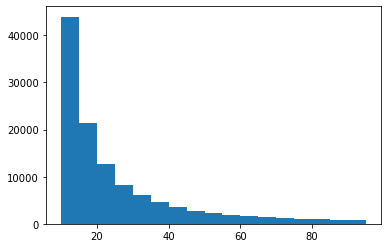

In [268]:
plt.hist([p[2] for p in all_data if p[2] < 100], range(10, 100, 5))
plt.show

#### Histogram of pairs with medium occurrance frequency

<function matplotlib.pyplot.show(close=None, block=None)>

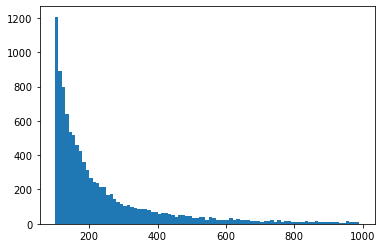

In [271]:
plt.hist([p[2] for p in all_data if p[2] < 1000 and p[2] >= 100], range(100, 1000, 10))
plt.show

#### Histogram of pairs with high occurrance frequency

In [276]:
sorted(all_data, key=lambda x: x[2], reverse=True)[:25]

[('eelmine', 'aasta', 53250),
 ('järgmine', 'aasta', 38107),
 ('viimane', 'aeg', 27915),
 ('käesolev', 'määrus', 27514),
 ('kogu', 'aeg', 24997),
 ('viimane', 'aasta', 24410),
 ('kohalik', 'omavalitsus', 24261),
 ('suur', 'osa', 22165),
 ('suur', 'tänu', 16634),
 ('eelmine', 'nädal', 15648),
 ('pikk', 'aeg', 14913),
 ('juriidiline', 'isik', 14328),
 ('tulev', 'aasta', 12634),
 ('kogu', 'maailm', 11843),
 ('lugupeetud', 'kolleeg', 11839),
 ('käesolev', 'aasta', 11753),
 ('hea', 'meel', 11562),
 ('käesolev', 'seadus', 9848),
 ('uus', 'aasta', 9580),
 ('järgmine', 'nädal', 9479),
 ('füüsiline', 'isik', 9028),
 ('viimane', 'päev', 8862),
 ('pädev', 'asutus', 8745),
 ('õige', 'aeg', 8742),
 ('järgmine', 'päev', 8542)]

As it is seen from the most frequent pairs printed out, there are very few pairs that occurred over 10000 times, so those will be left out of the histogram to make it more readable.

<function matplotlib.pyplot.show(close=None, block=None)>

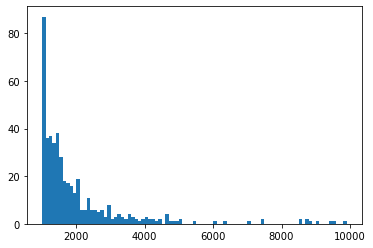

In [278]:
plt.hist([p[2] for p in all_data if p[2] >= 1000], range(1000, 10000, 100))
plt.show

### Histograms based on adjective count per noun

In [252]:
try:
    cursor.execute("SELECT noun, COUNT(adjective) FROM all_pairs_counts WHERE count >= 10 GROUP BY noun")
    adj_counts_per_noun = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [253]:
adj_counts_per_noun[:3]

[('läbivaatamine', 10), ('kuulsus', 29), ('harjutus', 22)]

#### Histogram of all data

As it is clearly seen, this doesn't really show much, as the overall variances are large, but most nouns are only described by very few adjectives.

(array([1.4503e+04, 1.7300e+02, 4.6000e+01, 8.0000e+00, 5.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  95.9, 190.8, 285.7, 380.6, 475.5, 570.4, 665.3, 760.2,
        855.1, 950. ]),
 <BarContainer object of 10 artists>)

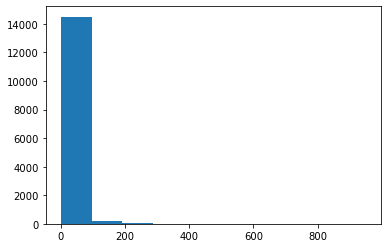

In [309]:
plt.hist([p[1] for p in adj_counts_per_noun])

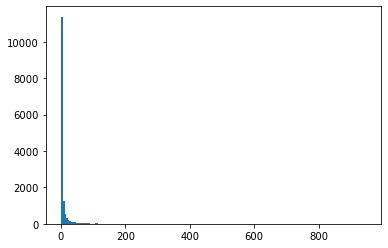

In [308]:
plt.hist([p[1] for p in adj_counts_per_noun], range(1, 951, 5))
plt.show()

#### Histogram of data with small adjective counts

In [293]:
small_counts = [p for p in adj_counts_per_noun if p[1] <= 10]

(array([6696., 2227., 1205.,  733.,  515.,  394.,  307.,  223.,  195.,
         130.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

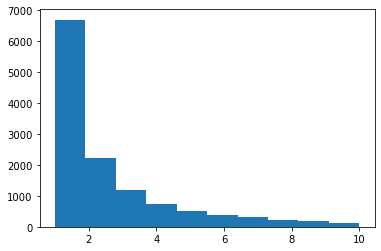

In [294]:
# is not really a histogram, because each bar is just the amount of nouns with that number of count (from 1 to 10),
# but it was good to bring it out separately, as a lot of nouns had been described by few adjectives
plt.hist([p[1] for p in small_counts])

#### Histogram of data with medium adjective counts

In [297]:
medium_counts = [p for p in adj_counts_per_noun if p[1] > 10 and p[1] < 100]

(array([450., 354., 225., 166., 136.,  94.,  79.,  64.,  68.,  40.,  43.,
         32.,  37.,  27.,  28.,  19.,  13.,  14.]),
 array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
         75,  80,  85,  90,  95, 100]),
 <BarContainer object of 18 artists>)

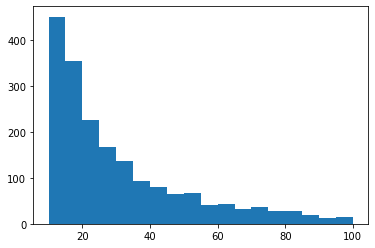

In [311]:
plt.hist([p[1] for p in medium_counts], range(10, 101, 5)) # step of 5, so bins are 11-14, 15-19, 20-24 and so on

(array([804., 357., 227., 144., 104.,  76.,  64.,  48.,  41.,  24.]),
 array([11. , 19.8, 28.6, 37.4, 46.2, 55. , 63.8, 72.6, 81.4, 90.2, 99. ]),
 <BarContainer object of 10 artists>)

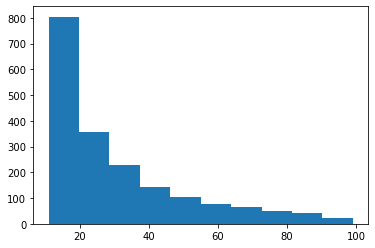

In [314]:
plt.hist([p[1] for p in medium_counts]) # default number of bins

#### Histogram of data with large adjective counts

In [299]:
large_counts = [p for p in adj_counts_per_noun if p[1] >= 100]

In [302]:
max([p[1] for p in large_counts])

950

(array([117.,  50.,  30.,  12.,   4.,   4.,   3.,   2.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
        750, 800, 850, 900, 950]),
 <BarContainer object of 17 artists>)

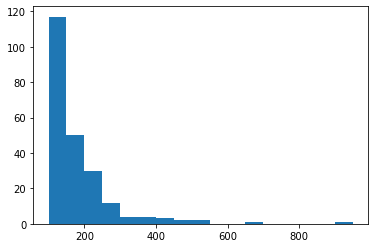

In [304]:
plt.hist([p[1] for p in large_counts], range(100, 1000, 50)) # step of 50

### Histograms based on nouns
These histograms use the counts of how many times the pairs appeared.

In [235]:
from collections import defaultdict

In [234]:
try:
    cursor.execute("SELECT * FROM all_pairs_counts WHERE count >= 10 GROUP BY noun, adjective, count")
    all_data = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [236]:
all_data[0]

('uus', '3-seeria', 11)

In [237]:
noun_counts = defaultdict(int)

for info in all_data:
    noun_counts[info[1]] += info[2]

#### Histogram on all data

(array([1.4696e+04, 3.1000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+01, 1.828520e+04, 3.656040e+04, 5.483560e+04,
        7.311080e+04, 9.138600e+04, 1.096612e+05, 1.279364e+05,
        1.462116e+05, 1.644868e+05, 1.827620e+05]),
 <BarContainer object of 10 artists>)

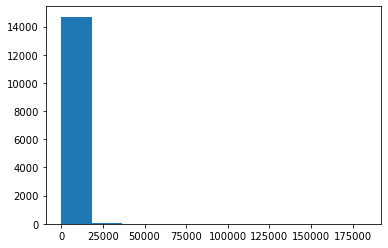

In [239]:
plt.hist(noun_counts.values())

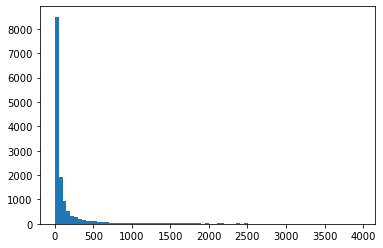

In [254]:
plt.hist(noun_counts.values(), range(1, 4000, 50)) # lõikab välja pärast 4000, aga seal olevad olid ka nii haruldased, et polnud graafikul näha
plt.show()

#### Histogram of data with small noun counts

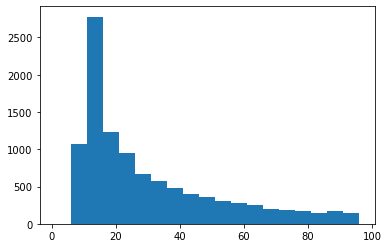

In [247]:
plt.hist([val for val in noun_counts.values() if val <= 100], range(1, 101, 5))
plt.show()

#### Histogram of data with medium noun counts

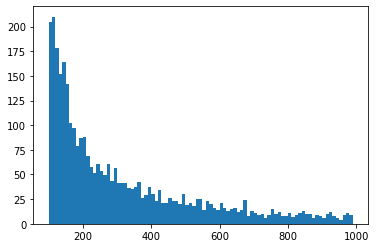

In [255]:
plt.hist([val for val in noun_counts.values() if val > 100 and val < 1000], range(100, 1000, 10))
plt.show()

#### Histogram of data with large noun counts

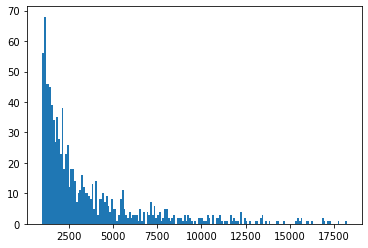

In [259]:
plt.hist([val for val in noun_counts.values() if val > 1000], range(1000, 18300, 100))
plt.show()

## Graph

### Subgraph

Creating a subgraph of ~10k most common pairs to visualise how the words are connected. The first 1000 and the next 9000 pairs are found and added separately, as they were first looked at separately.

In [28]:
import networkx as nx

In [29]:
cursor.execute("SELECT * FROM all_pairs_counts")
all_pairs = cursor.fetchall()

In [30]:
all_pairs = sorted(all_pairs, key = lambda x: x[2], reverse=True)

In [31]:
top1000 = all_pairs[:1001]

In [32]:
nouns = list(set([pair[1] for pair in top1000]))
adjectives = list(set([pair[0] for pair in top1000]))

In [33]:
edges = [(p[0], p[1]) for p in top1000]

In [34]:
edges[:3]

[('eelmine', 'aasta'), ('järgmine', 'aasta'), ('viimane', 'aeg')]

In [35]:
G = nx.Graph()

In [36]:
G.add_nodes_from(nouns, pos='noun')
G.add_nodes_from(adjectives, pos='adjective')

In [37]:
G.add_edges_from(edges, frequency='top1000')

In [39]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len)).copy()

In [40]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [41]:
print("Number of subcomponents:", len(S))

Number of subcomponents: 44


In [70]:
top10000 = all_pairs[1001:10079]

In [71]:
G.add_nodes_from(list(set([pair[1] for pair in top10000])), pos='noun')
G.add_nodes_from(list(set([pair[0] for pair in top10000])), pos='adjective')

In [72]:
edges10k = [(p[0], p[1]) for p in top10000]

In [79]:
G.add_edges_from(edges10k, frequency='top10000')

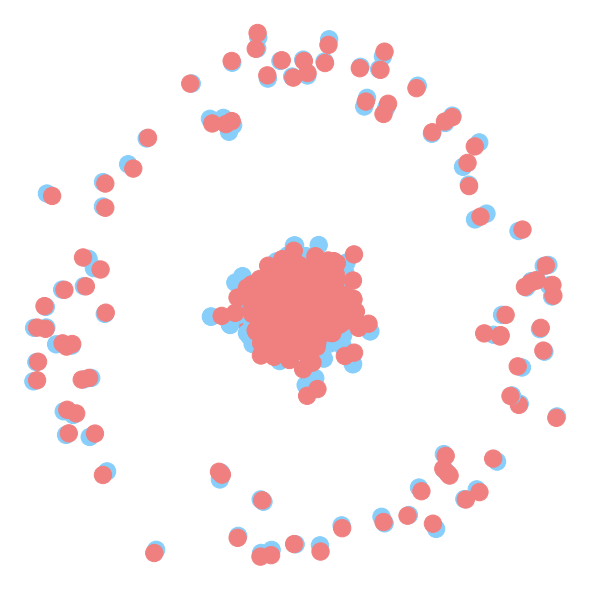

In [83]:
plt.figure(figsize=(8, 8))
#pos = nx.drawing.layout.circular_layout(G)
nx.draw(G, node_color=['lightskyblue' if G.nodes[node]['pos'] == 'noun' else 'lightcoral' for node in G.nodes()], edge_color=['black' if G.edges[edge]['frequency'] == 'top1000' else 'purple' for edge in G.edges()])
# plt.savefig("graaf_koik.png")
plt.show()

In [81]:
largest_cc2 = G.subgraph(max(nx.connected_components(G), key=len)).copy()

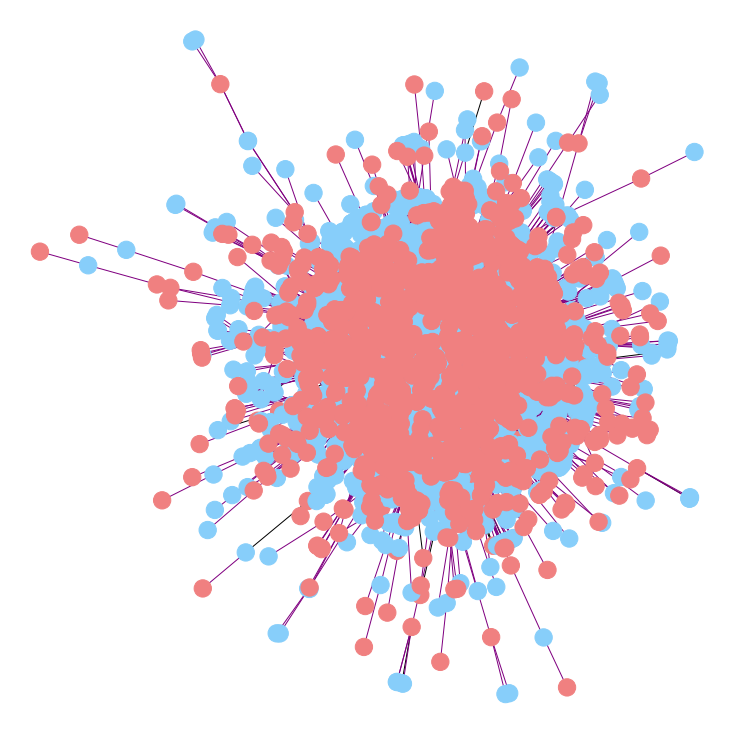

In [84]:
plt.figure(figsize=(10, 10))
#pos = nx.drawing.layout.circular_layout(G)
nx.draw(largest_cc2, node_color=['lightskyblue' if largest_cc2.nodes[node]['pos'] == 'noun' else 'lightcoral' for node in largest_cc2.nodes()], edge_color=['black' if largest_cc2.edges[edge]['frequency'] == 'top1000' else 'purple' for edge in largest_cc2.edges()])
# plt.savefig("graaf_suurim_alamkomponent.png")
plt.show()

### Entire graph

Graph creation and exploring of all pairs left after the preprocessing so the final data could be saved.

In [94]:
cursor.execute("SELECT * FROM all_pairs_counts WHERE count >= 10")
all_pairs = cursor.fetchall()

In [95]:
all_nouns = list(set([pair[1] for pair in all_pairs]))
all_adjectives = list(set([pair[0] for pair in all_pairs]))

In [96]:
graph = nx.Graph()

In [97]:
graph.add_nodes_from(all_nouns, pos='noun')
graph.add_nodes_from(all_adjectives, pos='adjective')

In [98]:
graph.add_edges_from([(p[0], p[1]) for p in all_pairs])

In [99]:
subgraphs = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]

In [100]:
largest_subgraph = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()

In [101]:
print("Number of connected components in the graph:", len(subgraphs))
print(f"Largest connected component includes {len(largest_subgraph.nodes())} words and {len(largest_subgraph.edges())} connections between those words")

Number of connected components in the graph: 131
Largest connected component includes 21952 words and 126285 connections between those words


In [102]:
print("Number of all words:", len(all_nouns) + len(all_adjectives))
print("Number of all pairs:", len(all_pairs))

Number of all words: 22318
Number of all pairs: 126445


In [57]:
print("Number of subgraphs with two words (one adjective and noun pair):", sum([1 for subgraph in subgraphs if len(subgraph.nodes()) == 2]))

Number of subgraphs with two words (one adjective and noun pair): 113


In [156]:
subgraphs[2].nodes()

NodeView(('näts', 'närimiskumm', 'suhkruvaba'))

## Statistics about nodes

In [15]:
try:
    cursor.execute("SELECT * FROM all_pairs_counts WHERE count >= 10")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [16]:
pairs[:10]

[('eelmine', 'aasta', 53250),
 ('järgmine', 'aasta', 38107),
 ('viimane', 'aeg', 27915),
 ('käesolev', 'määrus', 27514),
 ('kogu', 'aeg', 24997),
 ('viimane', 'aasta', 24410),
 ('kohalik', 'omavalitsus', 24261),
 ('suur', 'osa', 22165),
 ('suur', 'tänu', 16634),
 ('eelmine', 'nädal', 15648)]

In [17]:
print("Number of all pairs:", len(pairs))

Number of all pairs: 126445


### Nouns

In [3]:
try:
    cursor.execute("SELECT noun, COUNT(adjective) FROM all_pairs_counts WHERE count >= 10 GROUP BY noun")
    adj_counts_per_noun = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [4]:
adj_counts_per_noun = sorted(adj_counts_per_noun, key=lambda x: x[1], reverse=True)

In [5]:
adj_counts_per_noun[:10]

[('inimene', 950),
 ('mees', 664),
 ('töö', 541),
 ('asi', 526),
 ('naine', 486),
 ('aeg', 452),
 ('sõna', 427),
 ('riik', 425),
 ('tegevus', 422),
 ('küsimus', 399)]

In [8]:
print("All nouns:", len(adj_counts_per_noun))
print("Nouns with only one adjective describing them:", len([pair for pair in adj_counts_per_noun if pair[1] == 1]))
print("Average number of adjectives per noun:", sum([adj_count[1] for adj_count in adj_counts_per_noun]) / len(adj_counts_per_noun))
print("Average number of adjectives per noun with nouns with one adj removed:", sum([adj_count[1] for adj_count in adj_counts_per_noun if adj_count[1] != 1]) / len([adj_count[1] for adj_count in adj_counts_per_noun if adj_count[1] != 1]))

All nouns: 14740
Nouns with only one adjective describing them: 6696
Average number of adjectives per noun: 8.578358208955224
Average number of adjectives per noun with nouns with one adj removed: 14.88674788662357


In [287]:
print("Random examples of nouns with only one adjective describing them: ", random.sample([pair[0] for pair in adj_counts_per_noun if pair[1] == 1], 5))

Random examples of nouns with only one adjective describing them:  ['parkimiskeeld', 'kapitaliturg', 'moemaja', 'mõisnik', 'mahhinatsioon']


### Adjectives

In [11]:
try:
    cursor.execute("SELECT adjective, COUNT(noun) FROM all_pairs_counts WHERE count >= 10 GROUP BY adjective")
    noun_counts_per_adj = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [12]:
noun_counts_per_adj = sorted(noun_counts_per_adj, key=lambda x: x[1], reverse=True)

In [13]:
noun_counts_per_adj[:10]

[('uus', 3609),
 ('suur', 2784),
 ('hea', 1569),
 ('olnud', 1498),
 ('väike', 1357),
 ('võimalik', 1345),
 ('viimane', 1293),
 ('kogu', 1195),
 ('erinev', 1162),
 ('vana', 985)]

In [14]:
print("All adjectives:", len(noun_counts_per_adj))
print("Adjectives that describe only one noun:", len([pair for pair in noun_counts_per_adj if pair[1] == 1]))
print("Average number of adjectives per noun:", sum([noun_count[1] for noun_count in noun_counts_per_adj]) / len(noun_counts_per_adj))
print("Average number of adjectives per noun with nouns with one adj removed:", sum([noun_count[1] for noun_count in noun_counts_per_adj if noun_count[1] != 1]) / len([noun_count[1] for noun_count in noun_counts_per_adj if noun_count[1] != 1]))

All adjectives: 7578
Adjectives that describe only one noun: 2967
Average number of adjectives per noun: 16.68580100290314
Average number of adjectives per noun with nouns with one adj removed: 26.779006723053566


In [292]:
print("Random examples of adjectives that describe only one noun: ", random.sample([pair[0] for pair in noun_counts_per_adj if pair[1] == 1], 5))

Random examples of adjectives that describe only one noun:  ['selginev', 'paradigmasisene', 'materiaaltehniline', 'loogilis-filosoofiline', 'maa-lähedane']


## New table with updated data

In [105]:
print("Number of all pairs with count >= 10", len(all_pairs))

Number of all pairs with count >= 10 126445


In [103]:
edges = largest_subgraph.edges()
final_pairs = [pair for pair in all_pairs if (pair[1], pair[0]) in edges]

In [106]:
print("Number of pairs in largest connected component", len(final_pairs))

Number of pairs in largest connected component 126288


In [107]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [108]:
# Create adjective and noun pair table
try:
    pair_table = "final_pairs"
    create_table_query = '''CREATE TABLE '''+ pair_table +''' 
              (adjective      TEXT    NOT NULL,
               noun           TEXT    NOT NULL,
               count          INT     NOT NULL   
               ); '''

    #Execute this command (SQL Query)
    cursor.execute(create_table_query)
    
    # Make the changes to the database persistent
    con.commit()
    print("Table ("+ pair_table +") created successfully in PostgreSQL ")
except (Exception, psycopg2.Error) as error:
    # if it exits with an exception the transaction is rolled back.
    con.rollback()
    print("Error while creating the table: ", error)

Table (final_pairs) created successfully in PostgreSQL 


In [110]:
try:
    cursor.executemany("INSERT INTO final_pairs VALUES (%s, %s, %s)", final_pairs)
    con.commit()
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [112]:
cursor.execute("SELECT * FROM final_pairs")
len(cursor.fetchall())

126288